## Pre-requisite

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install adjustText kneed bertopic sacremoses

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install -U tensorflow-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.6 MB/s eta 0:00:00


## Code

In [6]:
import os
import json
import re
import textwrap
import pickle
import scipy
import ast
import math

import statsmodels as sm
import statsmodels.api as sm
import statsmodels as sm

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import get_cmap
cmap_autumn = get_cmap('autumn')
cmap_winter = get_cmap('winter')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from adjustText import adjust_text

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

from kneed import KneeLocator

from bertopic import BERTopic

import gensim
from gensim import corpora, models
from gensim.models import word2vec, Word2Vec
import gensim.corpora as corpora

# from transformers import pipeline
# multilingual_classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

from datetime import datetime, timedelta
from itertools import islice
from collections import Counter, defaultdict

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity

from tqdm import tqdm
import torch

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import BertConfig
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')
# bert_embeddings = list(model.children())[0]
# bert_word_embeddings = list(bert_embeddings.children())[0]
# mat = bert_word_embeddings.weight.data.numpy()

start = datetime.strptime("01-01-2018", "%d-%m-%Y")
end = datetime.strptime("31-12-2022", "%d-%m-%Y")
dates = [start + timedelta(days=x) for x in range(0, (end-start).days)]
x = np.linspace(1, len(dates), len(dates))

weight_for_gt = {
    "climate_engineering": 795000000,
    "geoengineering": 7530000,
    "solar_geoengineering": 1890000,
    "carbon_capture_and_removal": 55900000,
    "stratospheric_aerosol_injection": 289000,
    "cloud_brightening": 7000000,
    "ocean_fertilization": 8410000,
    "biochar": 24300000,
    "afforestation": 15000000,
    "reforestation": 30600000,
    "ecosystem_restoration": 139000000,
}

scaler = MinMaxScaler()

stopwords = set(STOPWORDS) | set(stopwords.words('english'))

stopwords_all = stopwords | set(["will", "may", "say", "says", "said", "told", "bbc", "video", "javascript", "sites",
                                 "mr", "year", "years", "people", "new", "number", "one", "two", "first", "last", "many", "much",
                                 "need", "want", "made", "make", "take", "time", "day", "part", "work", "play", "played",
                                 "u", "n't", "content", "enable", "browser",
                                 "us", "eu", "uk", "country", "ms.", "mr.", "even", "use", "go",
                                 "de", "la", "que", "en", "lo", "el", "includ", "include", "call",
                                 "http", "https", "link"])

stopwords_all_stem = set([p_stemmer.stem(token) for token in stopwords_all])

geoengineering_terms_category_dict = {}
geoengineering_terms_category = []
with open("geoengineering_terms_category.txt") as file:
    for line in file.readlines():
        thisone = " ".join([p_stemmer.stem(i) for i in line.strip().lower().split()])
        geoengineering_terms_category_dict[thisone] = line.strip().lower()
        geoengineering_terms_category.append(thisone)
geoengineering_terms_category_process = ["_".join(i.split()) for i in geoengineering_terms_category] + ["geoengin"]

geoengineering_terms_influencer_dict = {}
geoengineering_terms_influencer = []
with open("geoengineering_terms_influencer.txt") as file:
    for line in file.readlines():
        thisone = " ".join([p_stemmer.stem(i) for i in line.strip().lower().split()])
        geoengineering_terms_influencer_dict[thisone] = line.strip().lower()
        geoengineering_terms_influencer.append(thisone)
geoengineering_terms_influencer_process = ["_".join(i.split()) for i in geoengineering_terms_influencer]

geoengineering_terms_influencer_dict_whole = geoengineering_terms_influencer_dict.copy()
for key, value in geoengineering_terms_influencer_dict.items():
    geoengineering_terms_influencer_dict_whole["_".join(value.split())] = value.title()
    geoengineering_terms_influencer_dict_whole["_".join(key.split())] = value.title()
    geoengineering_terms_influencer_dict_whole[key] = value.title()

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def plot_estimate_confidence(mean_conf, ax, color=["skyblue", "blue"]):
    categories = mean_conf.columns
    estimates = mean_conf.iloc[0]
    conf_intervals = list(mean_conf.iloc[1:, :].T.itertuples(index=False, name=None))

    for i, (estimate, interval) in enumerate(zip(estimates, conf_intervals)):
        ax.plot([interval[0], interval[1]], [i, i], color=color[0])
        ax.plot(estimate, i, 'o', color=color[1])
    ax.set_yticks(np.arange(len(categories)), categories)

def co_occurrence(sentences, window_size):
    d = defaultdict(int)
    vocab = set()

    for text in tqdm(sentences):
        for i in range(len(text)):
            token = text[i]
            vocab.add(token)
            next_token = text[i+1:i+1+window_size]
            for t in next_token:
                key = tuple(sorted([t, token]))
                d[key] += 1

    vocab = sorted(vocab)
    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)

    for key, value in tqdm(d.items()):
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    return df

def tsne_plot(model, ax=None, random_state=1):
    labels, tokens = [], []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=random_state)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x, y = [], []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    if not ax:
        fig, ax = plt.subplots(figsize=(12, 8))

    for i in tqdm(range(len(x))):
        if labels[i] in geoengineering_terms_category_process:
            ax.annotate(" ".join(labels[i].split("_")), xy=(x[i], y[i]), xytext=(5, 2),
                        textcoords='offset points', ha='right', va='bottom')
            ax.scatter(x[i], y[i], s=1)
        elif labels[i] in geoengineering_terms_influencer_process:
            ax.annotate(" ".join(labels[i].split("_")), xy=(x[i], y[i]), xytext=(5, 2),
                        textcoords='offset points', ha='right', va='bottom', color="red")
            ax.scatter(x[i], y[i], s=1)
        # else:
        #     ax.scatter(x[i], y[i], s=0.05)

def pickup_data(root):
    if root == "bbc":
        title_split = " - BBC "
    elif root == "nytimes":
        title_split = " - The New York Times"
    titles = []
    contents = []
    texts = []
    texts_multi = []
    list_root = [i for i in os.listdir(root) if i [0] != "."]
    years = sorted(list_root, key=int)
    for year in years:
        months = sorted(os.listdir(os.path.join(root, year)), key=int)
        for month in months:
            days = sorted(os.listdir(os.path.join(root, year, month)), key=int)
            for day in days:
                date = os.path.join(year, month, day)
                with open(os.path.join(root, year, month, day, 'articles')) as txt:
                    articles = json.loads(txt.read())
                    for article in articles["articles"]:
                        title = article["title"].split(title_split)[0]
                        content = article["content"]
                        description = article["description"]
                        if description is None:
                            description_input = " "
                        else:
                            description_input = " " + description + " "

                        titles += [[date, title]]
                        contents += [[date, content]]
                        texts += [[date, title + description_input + content]]
                        texts_multi += [[date, title, description, content]]
    return titles, contents, texts, texts_multi

def lower_df_data(df, index=[1,2,3]):
    if type(index) == int:
        index = [index]
    for i in index:
        df[i] = df[i].str.lower()
    return df

def choose_df_data(df, index=[1,2,3], words_need=""):
    if type(index) == int:
        index = [index]
    df_contains_temp = False
    for i in index:
        df_contains_temp = df_contains_temp | df[i].str.contains(words_need)
    df = df[df_contains_temp]
    return df

def stack_df_data(df, index=[1,2,3]):
    if type(index) == int:
        index = [index]
    df_stack = []
    for _, row in df.iterrows():
        for i in index:
            df_stack.append([row[0], row[i]])
    df_stack = pd.DataFrame(df_stack)
    return df_stack

def word_process(text):
    if text is None:
        return [""]
    text_token = nltk.word_tokenize(text)
    text_token_nonstop = [token for token in text_token if (token[0].isalpha()) and (token not in stopwords_all)]
    text_token_nonstop_stem = [p_stemmer.stem(token) for token in text_token_nonstop]
    text_token_nonstop_stem_combine = " ".join(text_token_nonstop_stem)
    for category in geoengineering_terms_category:
        if category in text_token_nonstop_stem_combine:
            text_token_nonstop_stem_combine = text_token_nonstop_stem_combine.replace(category, "_".join(category.split()))
    for category in geoengineering_terms_influencer:
        if category in text_token_nonstop_stem_combine:
            text_token_nonstop_stem_combine = text_token_nonstop_stem_combine.replace(category, "_".join(category.split()))
    return text_token_nonstop_stem_combine.split()

def process_df_data(df, index=[1,2,3]):
    if type(index) == int:
        index = [index]
    for i in index:
        df[i] = df[i].apply(lambda x: word_process(x))
    return df

def pre_workflow(news, words_need, process=True):
    _, _, _, data = pickup_data(news)
    data = pd.DataFrame(data)
    data[0]= pd.to_datetime(data[0]).dt.strftime('%Y/%m/%d')
    data = lower_df_data(data)
    data = choose_df_data(data, words_need=words_need)
    data = stack_df_data(data)
    if process:
        data = process_df_data(data, index=1)
    return data

def time_range_split(start, end, num):
    if num == 5:
        return ["2018/01/01", "2018/12/31",
                "2019/01/01", "2019/12/31",
                "2020/01/01", "2020/12/31",
                "2021/01/01", "2021/12/31",
                "2022/01/01", "2022/12/31"]
    fmt = "%Y/%m/%d"
    start = datetime.strptime(start, fmt)
    end = datetime.strptime(end, fmt)
    diff = (end - start) / num
    split_points = []
    for i in range(num):
        split_points.append((start + diff * i).strftime(fmt))
        if i > 0:
            split_points.append((start + diff * i + timedelta(days = 1)).strftime(fmt))
    split_points.append(end.strftime(fmt))
    return split_points

def split_df_data(data, num, time_col_number = 0):
    split_points = time_range_split(data.iloc[0, time_col_number], data.iloc[-1, time_col_number], num)
    data_split = []
    for i in range(len(split_points) // 2):
        data_split.append(data[(data.iloc[:, time_col_number] >= split_points[i*2]) & (data.iloc[:, time_col_number] <= split_points[i*2+1])])
    return data_split, split_points

def draw_wordcloud(words, stopwords = stopwords, ax=None, width = 800, height = 400):
    wordcloud = WordCloud(width = width, height = height,
                    background_color ='white',
                    stopwords = stopwords,
                    collocation_threshold = 1000,
                    min_font_size = 5).generate(words)

    if ax is None:
        _, ax = plt.subplots(figsize = (8, 8), facecolor = None)
        ax.imshow(wordcloud)
    else:
        ax.imshow(wordcloud)

    ax.axis("off");

def draw_wordcloud_df_data(data, ax=None, width = 800, height = 400, text_col=1):
    words = " ".join(data[text_col].apply(lambda x: " ".join(x)))
    draw_wordcloud(words, stopwords = stopwords_all_stem, ax=ax, width = width, height = height)

def draw_wordcloud_list_data(data_splits, data_split_points, title="", text_col=1):
    fig, axes = plt.subplots(nrows=1, ncols=len(data_splits), figsize=(30,10))
    for i, data_split in enumerate(data_splits):
        draw_wordcloud_df_data(data_split, ax = axes[i], width = 800, height = 1600, text_col=text_col)
        axes[i].set_title("%s ~ %s" % (data_split_points[i*2], data_split_points[i*2+1]))
    fig.suptitle(title)
    fig.tight_layout();

def draw_termfreq_df_data(data, num_terms, ax=None, text_col=1):
    words = list([a for b in data[text_col].tolist() for a in b])
    words_termfreq = Counter(words).most_common(num_terms)
    words_termfreq = pd.DataFrame(words_termfreq).set_index(0)[::-1]
    words_termfreq.plot.barh(ax=ax)

def draw_termfreq_list_data(data_splits, data_split_points, num_terms, title="", text_col=1):
    fig, axes = plt.subplots(nrows=1, ncols=len(data_splits), figsize=(20,8))
    for i, data_split in enumerate(data_splits):
        draw_termfreq_df_data(data_split, num_terms, ax=axes[i], text_col=text_col)
        axes[i].legend().set_visible(False)
        axes[i].set_title("%s ~ %s" % (data_split_points[i*2], data_split_points[i*2+1]))
        axes[i].set_ylabel("")
    fig.suptitle(title)
    fig.tight_layout();

def draw_lda_df_data(data, num_topics, num_words, show_formatted=False):
    dictionary = corpora.Dictionary(data[1])
    corpus = [dictionary.doc2bow(i) for i in data[1]]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, random_state=706)
    if show_formatted:
        print(ldamodel.print_topics(num_topics=num_topics, num_words=num_words))
    lda_results = ldamodel.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    return lda_results

def draw_lda_list_data(data_splits, data_split_points, num_topics, num_words, title=""):
    print(title, end="\n\n")
    for i, data_split in enumerate(data_splits):
        print("%s ~ %s" % (data_split_points[i*2], data_split_points[i*2+1]))
        lda_results = draw_lda_df_data(data_split, num_topics, num_words)
        for topic in lda_results:
            print()
            for token in topic[1]:
                print(token[0], token[1])
        print("\n\n\n")

def compute_embedding(sentence):
    # Tokenize and encode the example sentence
    example_encoding = tokenizer.batch_encode_plus(
        [sentence],
        padding=True,
        truncation=True,
        return_tensors='pt',
        add_special_tokens=True
    )
    example_input_ids = example_encoding['input_ids']
    example_attention_mask = example_encoding['attention_mask']

    # Generate embeddings for the example sentence
    with torch.no_grad():
        example_outputs = model(example_input_ids, attention_mask=example_attention_mask)
        example_sentence_embedding = example_outputs.last_hidden_state.mean(dim=1)

    return example_sentence_embedding

tokenizer_tuned = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
config_tuned = BertConfig.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", output_hidden_states=True)
model_tuned = AutoModelForSequenceClassification.from_pretrained("model/", config=config_tuned)

def get_hidden_states(encoded, token_ids_word, model):
  with torch.no_grad():
    output = model(**encoded)
  states = output.hidden_states
  output = torch.stack([states[i] for i in [0]]).sum(0).squeeze()
  word_tokens_output = output[token_ids_word]
  return word_tokens_output.mean(dim=0).reshape(1, -1)

def get_word_tuned_vector(sent, tokenizer=tokenizer_tuned, model=model_tuned):
  encoded = tokenizer.encode_plus(sent, return_tensors="pt")
  token_ids_word = np.where(np.array(encoded.word_ids()) == 0)
  return get_hidden_states(encoded, token_ids_word, model)

def get_sencentence_tuned_vector(sent):
  sents = sent.split()
  if len(sents) > 1:
    return np.mean([get_word_tuned_vector(i) for i in sents], axis=0)
  else:
    return get_word_tuned_vector(sent)


<ipython-input-6-1834d7b6e49f>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_autumn = get_cmap('autumn')
<ipython-input-6-1834d7b6e49f>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_winter = get_cmap('winter')
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
geoengineering_terms = []
with open("geoengineering_terms_pruning.txt") as file:
    for line in file.readlines():
        geoengineering_terms += line.strip().lower().split()
words_need = "|".join(geoengineering_terms)
words_need

'geoengineer|geoengineering|solar|radiation|greenhouse|carbon|stratospheric|aerosol|albedo|methane|fertilization|weathering|biochar|afforestation|reforestation|ecosystem|restoration|soil|sequestration|bioenergy'

In [8]:
geoengineering_terms_temp = []
with open("geoengineering_terms_pruning.txt") as file:
    for line in file.readlines():
        geoengineering_terms_temp += line.strip().lower().split()
with open('geoengineering_terms_influencer.txt') as file:
    geoengineering_terms_temp += [i.strip().lower() for i in file.readlines()]
words_need_temp = "|".join(geoengineering_terms_temp)
words_need_temp

'geoengineer|geoengineering|solar|radiation|greenhouse|carbon|stratospheric|aerosol|albedo|methane|fertilization|weathering|biochar|afforestation|reforestation|ecosystem|restoration|soil|sequestration|bioenergy|biodiversity|deforestation|natural disaster|sea level rise|plastic pollution|ocean acidification|air pollution|global warming|overfishing|climate change'

In [ ]:
# bbc_unprocess_temp = pre_workflow("bbc", words_need_temp, process=False)
# nytimes_unprocess_temp = pre_workflow("nytimes", words_need_temp, process=False)

In [ ]:
# _, _, _, bbc_all = pickup_data("bbc")
# _, _, _, nytimes_all = pickup_data("nytimes")

In [ ]:
#bbc_unprocess = pre_workflow("bbc", words_need, process=False)
#bbc_corpus = bbc[1].to_list()

#nytimes_unprocess = pre_workflow("nytimes", words_need, process=False)
#nytimes_corpus = nytimes[1].to_list()

In [9]:
bbc_unprocess = pd.read_csv('bbc_unprocess.csv')
nytimes_unprocess = pd.read_csv('nytimes_unprocess.csv')

bbc_processed = pd.read_csv('bbc_processed.csv')
nytimes_processed = pd.read_csv('nytimes_processed.csv')

with open('bbc_corpus', 'rb') as f:
    bbc_corpus = pickle.load(f)
with open('nytimes_corpus', 'rb') as f:
    nytimes_corpus = pickle.load(f)

In [10]:
bbc_daily = bbc_unprocess["0"].value_counts().sort_index().reset_index()
bbc_daily["index"] = pd.to_datetime(bbc_daily["0"])
bbc_weekly = bbc_daily.groupby(pd.Grouper(key="index", freq='W-MON')).sum()
bbc_weekly = bbc_weekly.rename({"0": "BBC"}, axis=1)

nytimes_daily = nytimes_processed["0"].value_counts().sort_index().reset_index()
nytimes_daily["index"] = pd.to_datetime(nytimes_daily["0"])
nytimes_weekly = nytimes_daily.groupby(pd.Grouper(key="index", freq='W-MON')).sum()
nytimes_weekly = nytimes_weekly.rename({"0": "NYTimes"}, axis=1)

In [ ]:
bbc_yearly = bbc_daily.groupby(pd.Grouper(key="index", freq='Y')).sum()

In [ ]:
nytimes_yearly = nytimes_daily.groupby(pd.Grouper(key="index", freq='Y')).sum()

In [ ]:
bbc_weekly.loc['2022-12-26'] += bbc_weekly.loc['2023-01-02']

In [ ]:
nytimes_weekly.loc['2022-12-26'] += nytimes_weekly.loc['2023-01-02']

In [ ]:
scipy.stats.pearsonr(bbc_weekly["BBC"], nytimes_weekly["NYTimes"])

PearsonRResult(statistic=0.45211989745395853, pvalue=1.3243205616730256e-14)

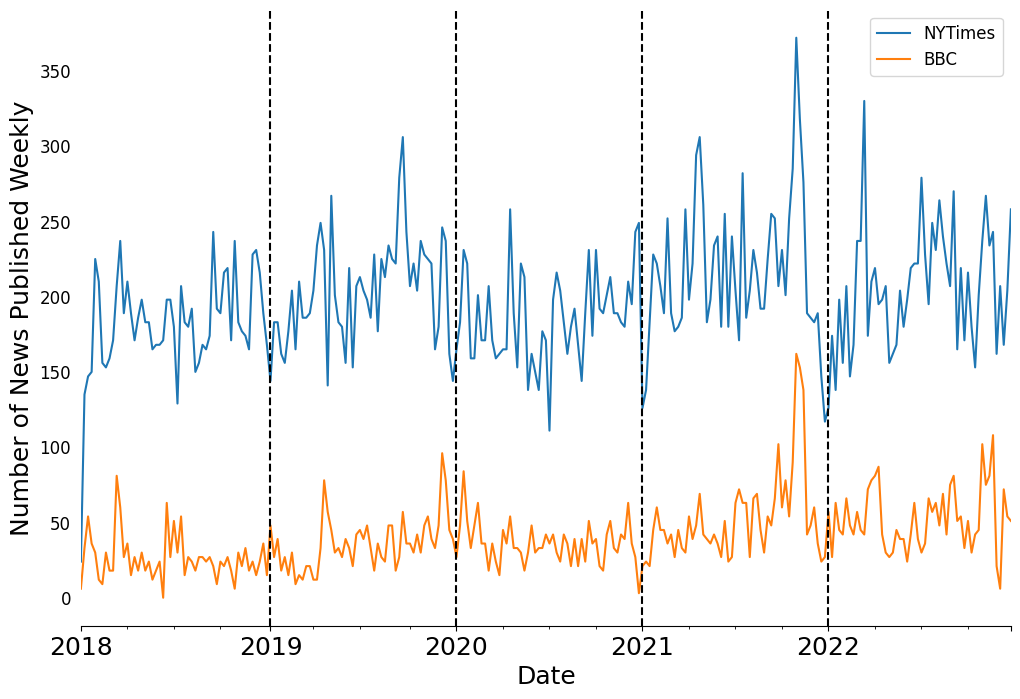

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

nytimes_weekly.iloc[:-1]["count"].plot(ax=ax, label="NYTimes")
bbc_weekly.iloc[:-1]["count"].plot(ax=ax, label="BBC")

ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

ax.axvline("2019-01-01", color="black", linestyle="--")
ax.axvline("2020-01-01", color="black", linestyle="--")
ax.axvline("2021-01-01", color="black", linestyle="--")
ax.axvline("2022-01-01", color="black", linestyle="--")

ax.set_xlabel("Date", fontsize=18)
ax.set_ylabel("Number of News Published Weekly", fontsize=18)

ax.legend(prop={'size': 12});

In [ ]:
length = set()
for i in bbc_unprocess["1"].tolist():
  length |= set(i.split())
for i in nytimes_processed["1"].tolist():
  length |= set(i.split())


In [ ]:
len(length)

315986

In [ ]:
nytimes_unprocess.shape

(51924, 2)

In [ ]:
bbc_unprocess.shape

(10590, 2)

In [ ]:
51924 + 10590

62514

### GT Pearson Correlation and BBC/NYTimes Distance*

In [ ]:
# bbc_word2vec = word2vec.Word2Vec(bbc_corpus, vector_size=100, window=5, min_count=1, workers=1)
# bbc_word2vec.save("bbc_word2vec.model")
# nytimes_word2vec = word2vec.Word2Vec(nytimes_corpus, vector_size=100, window=5, min_count=1, workers=1)
# nytimes_word2vec.save("nytimes_word2vec.model")

In [11]:
bbc_word2vec = Word2Vec.load("bbc_word2vec.model")
nytimes_word2vec = Word2Vec.load("nytimes_word2vec.model")

In [12]:
geoengineering_terms_category_process_dedup = sorted(list(set(geoengineering_terms_category_process)))
bbc_distance_matrix = pd.DataFrame(np.zeros([len(geoengineering_terms_category_process_dedup), len(geoengineering_terms_influencer_process)]),
                                   index=geoengineering_terms_category_process_dedup, columns=geoengineering_terms_influencer_process)
nytimes_distance_matrix = pd.DataFrame(np.zeros([len(geoengineering_terms_category_process_dedup), len(geoengineering_terms_influencer_process)]),
                                   index=geoengineering_terms_category_process_dedup, columns=geoengineering_terms_influencer_process)
for category in geoengineering_terms_category_process_dedup:
    for influencer in geoengineering_terms_influencer_process:
        try:
            cid = bbc_word2vec.wv.similarity(category, influencer)
            bbc_distance_matrix.at[category, influencer] = cid
        except KeyError:
            print(category, "or", influencer, "not exist in BBC")
            bbc_distance_matrix.at[category, influencer] = None

        try:
            cid = nytimes_word2vec.wv.similarity(category, influencer)
            nytimes_distance_matrix.at[category, influencer] = cid
        except KeyError:
            print(category, "or", influencer, "not exist in NYTimes")
            nytimes_distance_matrix.at[category, influencer] = None

biochar or biodivers not exist in BBC
biochar or deforest not exist in BBC
biochar or natur_disast not exist in BBC
biochar or sea_level_rise not exist in BBC
biochar or plastic_pollut not exist in BBC
biochar or ocean_acidif not exist in BBC
biochar or air_pollut not exist in BBC
biochar or global_warm not exist in BBC
biochar or overfish not exist in BBC
biochar or climat_chang not exist in BBC
blue_carbon_manag or biodivers not exist in BBC
blue_carbon_manag or biodivers not exist in NYTimes
blue_carbon_manag or deforest not exist in BBC
blue_carbon_manag or deforest not exist in NYTimes
blue_carbon_manag or natur_disast not exist in BBC
blue_carbon_manag or natur_disast not exist in NYTimes
blue_carbon_manag or sea_level_rise not exist in BBC
blue_carbon_manag or sea_level_rise not exist in NYTimes
blue_carbon_manag or plastic_pollut not exist in BBC
blue_carbon_manag or plastic_pollut not exist in NYTimes
blue_carbon_manag or ocean_acidif not exist in BBC
blue_carbon_manag or ocea

In [15]:
bbc_mean_conf[bbc_mean_conf.columns[bbc_mean_conf.iloc[0].argsort()[::-1]]]

,plastic_pollut,overfish,biodivers,sea_level_rise,ocean_acidif,natur_disast,air_pollut,deforest,global_warm,climat_chang
0,0.418974,0.389078,0.302961,0.289865,0.275797,0.274535,0.272778,0.212458,0.204907,0.154090
1,0.209828,0.177177,0.125514,0.079918,0.035596,0.001796,0.037345,-0.005113,0.010792,-0.001422
2,0.628120,0.600979,0.480408,0.499812,0.515998,0.547273,0.508210,0.430029,0.399023,0.309603


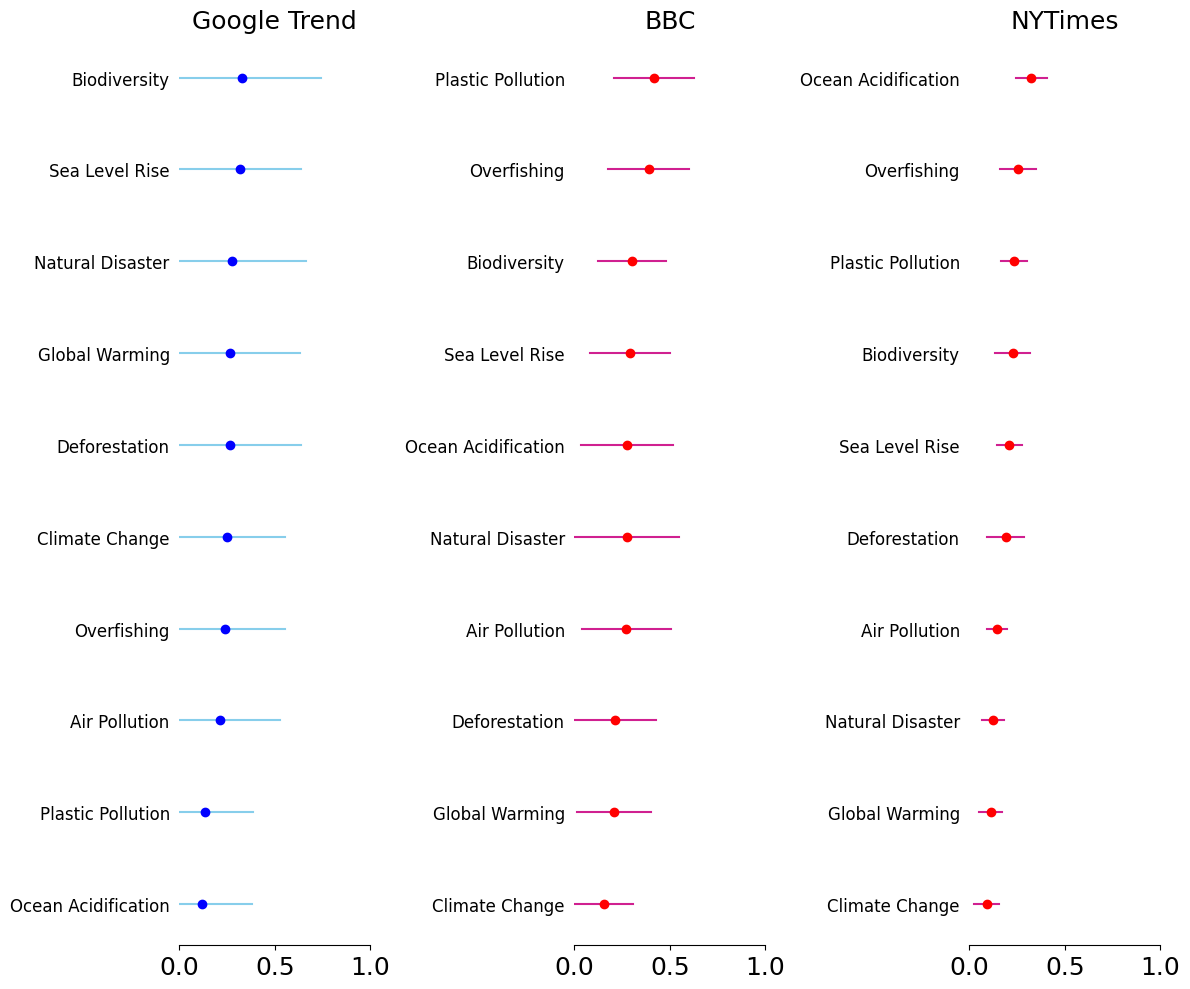

In [17]:
gt_correlation = pd.read_csv("GoogleTrendsCorrelation.csv", index_col=0)
gt_correlation = np.abs(gt_correlation)
gt_mean_conf = pd.DataFrame(np.zeros([3,10]), index=[0,1,2], columns=['ocean_acidification', 'climate_change', 'air_pollution',
                                                                      'plastic_pollution', 'natural_disaster', 'overfishing',
                                                                      'sea_level_rise', 'deforestation', 'global_warming', 'biodiversity'])
weights = [weight_for_gt[i] if i in weight_for_gt else 0 for i in gt_correlation.index]
weights = normalize_data(weights)
for column in gt_correlation.columns:
    ds = sm.stats.weightstats.DescrStatsW(gt_correlation[column], weights=weights)
    gt_mean_conf.at[0, column] = ds.mean
    left, right = ds.zconfint_mean()
    gt_mean_conf.at[1, column] = left
    gt_mean_conf.at[2, column] = right
gt_mean_conf = gt_mean_conf[gt_mean_conf.columns[gt_mean_conf.iloc[0].argsort()]]
gt_mean_conf = gt_mean_conf.rename(geoengineering_terms_influencer_dict_whole, axis=1)

bbc_mean_conf = bbc_distance_matrix.dropna().apply(mean_confidence_interval)
bbc_mean_conf = bbc_mean_conf[bbc_mean_conf.columns[bbc_mean_conf.iloc[0].argsort()]]
bbc_mean_conf = bbc_mean_conf.rename(geoengineering_terms_influencer_dict_whole, axis=1)

nytimes_mean_conf = nytimes_distance_matrix.dropna().apply(mean_confidence_interval)
nytimes_mean_conf = nytimes_mean_conf[nytimes_mean_conf.columns[nytimes_mean_conf.iloc[0].argsort()]]
nytimes_mean_conf = nytimes_mean_conf.rename(geoengineering_terms_influencer_dict_whole, axis=1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 10))
plot_estimate_confidence(gt_mean_conf, axes[0])
plot_estimate_confidence(bbc_mean_conf, axes[1], ["#D02090", "red"])
plot_estimate_confidence(nytimes_mean_conf, axes[2], ["#D02090", "red"])

axes[0].set_title("Google Trend", fontsize=18)
axes[1].set_title("BBC", fontsize=18)
axes[2].set_title("NYTimes", fontsize=18)

for ax in axes:
    ax.tick_params(axis='y', which='major', labelsize=12)
    ax.tick_params(axis='x', which='major', labelsize=18)
    ax.set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

plt.tight_layout()

In [18]:
category = []
with open("geoengineering_terms_category.txt") as file:
    for line in file.readlines():
      category.append(line.lower().strip())
category = sorted(category)
influencer = []
with open("geoengineering_terms_influencer.txt") as file:
    for line in file.readlines():
      influencer.append(line.lower().strip())
influencer = sorted(influencer)

cosine_matrix = pd.DataFrame(np.zeros([len(category), len(influencer)]), index=category, columns=influencer)
for c in category:
    for i in influencer:
      cosine_matrix.loc[c, i] = cosine_similarity(compute_embedding(c), compute_embedding(i))[0][0]

cosine_matrix_mean_conf = cosine_matrix.dropna().apply(mean_confidence_interval)
cosine_matrix_mean_conf = cosine_matrix_mean_conf[cosine_matrix_mean_conf.columns[cosine_matrix_mean_conf.iloc[0].argsort()[::-1]]]
cosine_matrix_mean_conf.columns = [i.title() for i in cosine_matrix_mean_conf.columns]

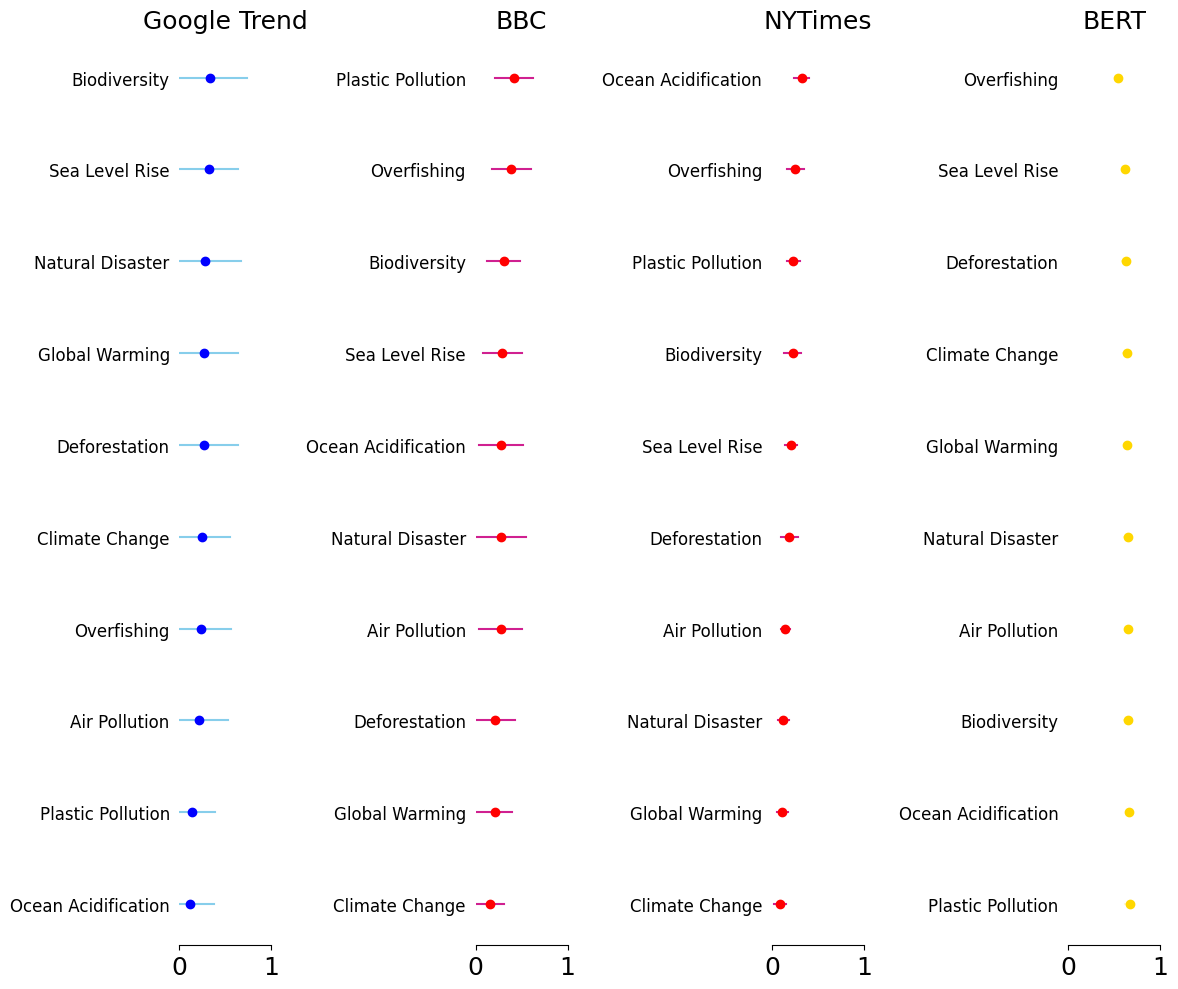

In [19]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 10))
plot_estimate_confidence(gt_mean_conf, axes[0])
plot_estimate_confidence(bbc_mean_conf, axes[1], ["#D02090", "red"])
plot_estimate_confidence(nytimes_mean_conf, axes[2], ["#D02090", "red"])
plot_estimate_confidence(cosine_matrix_mean_conf, axes[3], ["lemonchiffon", "gold"])

axes[0].set_title("Google Trend", fontsize=18)
axes[1].set_title("BBC", fontsize=18)
axes[2].set_title("NYTimes", fontsize=18)
axes[3].set_title("BERT", fontsize=18)

for ax in axes:
    ax.tick_params(axis='y', which='major', labelsize=12)
    ax.tick_params(axis='x', which='major', labelsize=18)
    ax.set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

plt.tight_layout()

In [20]:
category = []
with open("geoengineering_terms_category.txt") as file:
    for line in file.readlines():
      category.append(line.lower().strip())
category = sorted(category)
influencer = []
with open("geoengineering_terms_influencer.txt") as file:
    for line in file.readlines():
      influencer.append(line.lower().strip())
influencer = sorted(influencer)

cosine_matrix_tuned = pd.DataFrame(np.zeros([len(category), len(influencer)]), index=category, columns=influencer)
for c in category:
    for i in influencer:
      cosine_matrix_tuned.loc[c, i] = cosine_similarity(get_sencentence_tuned_vector(c), get_sencentence_tuned_vector(i))[0][0]

cosine_matrix_mean_conf_tuned = cosine_matrix_tuned.dropna().apply(mean_confidence_interval)
cosine_matrix_mean_conf_tuned = cosine_matrix_mean_conf_tuned[cosine_matrix_mean_conf_tuned.columns[cosine_matrix_mean_conf_tuned.iloc[0].argsort()[::-1]]]
cosine_matrix_mean_conf_tuned.columns = [i.title() for i in cosine_matrix_mean_conf_tuned.columns]

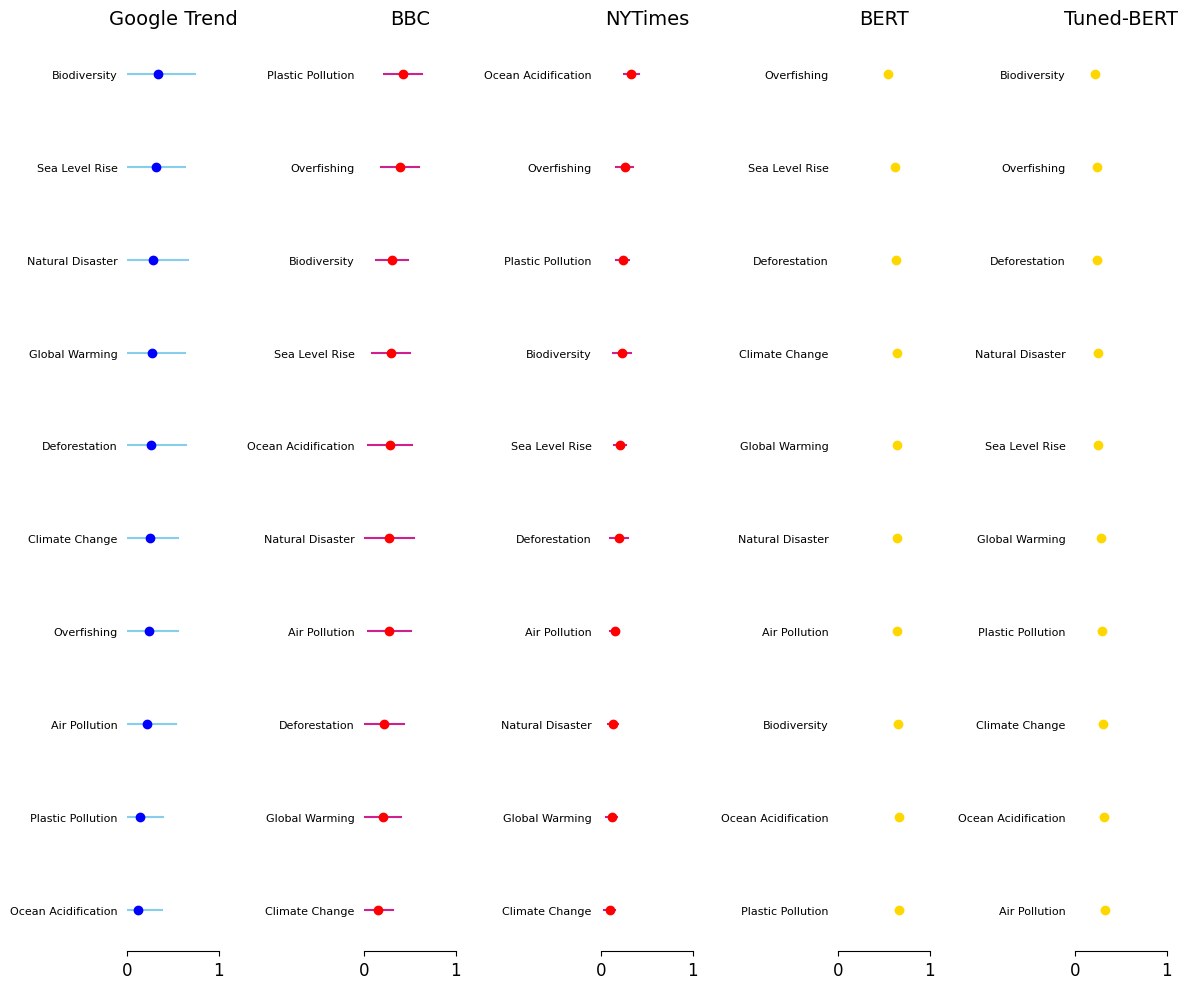

In [21]:
fig, axes = plt.subplots(ncols=5, figsize=(12, 10))
plot_estimate_confidence(gt_mean_conf, axes[0])
plot_estimate_confidence(bbc_mean_conf, axes[1], ["#D02090", "red"])
plot_estimate_confidence(nytimes_mean_conf, axes[2], ["#D02090", "red"])
plot_estimate_confidence(cosine_matrix_mean_conf, axes[3], ["lemonchiffon", "gold"])
plot_estimate_confidence(cosine_matrix_mean_conf_tuned, axes[4], ["lemonchiffon", "gold"])

axes[0].set_title("Google Trend", fontsize=14)
axes[1].set_title("BBC", fontsize=14)
axes[2].set_title("NYTimes", fontsize=14)
axes[3].set_title("BERT", fontsize=14)
axes[4].set_title("Tuned-BERT", fontsize=14)

for ax in axes:
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.tick_params(axis='x', which='major', labelsize=12)
    ax.set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

plt.tight_layout()

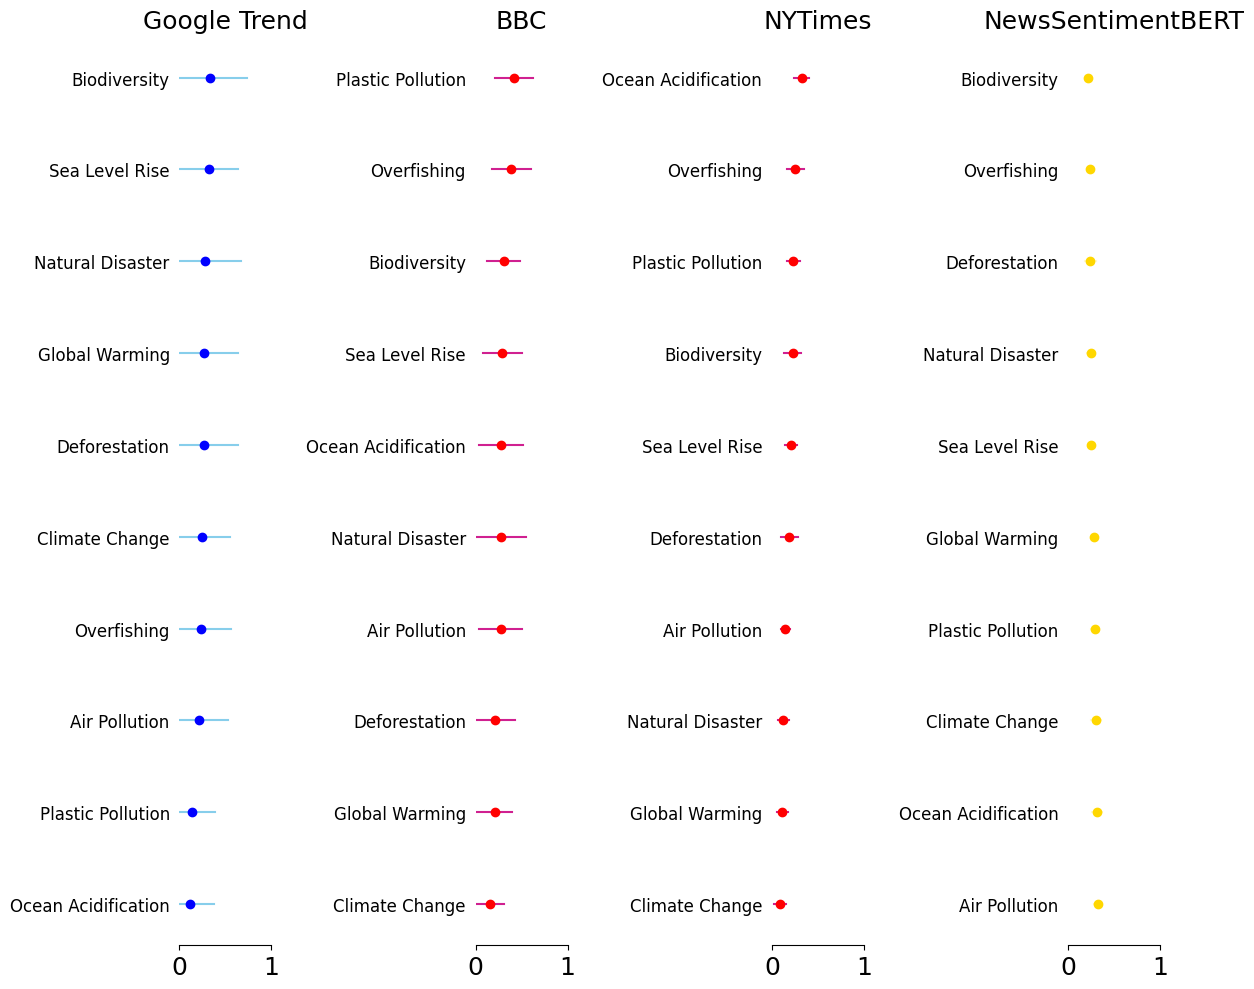

In [22]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 10))
plot_estimate_confidence(gt_mean_conf, axes[0])
plot_estimate_confidence(bbc_mean_conf, axes[1], ["#D02090", "red"])
plot_estimate_confidence(nytimes_mean_conf, axes[2], ["#D02090", "red"])
plot_estimate_confidence(cosine_matrix_mean_conf_tuned, axes[3], ["lemonchiffon", "gold"])

axes[0].set_title("Google Trend", fontsize=18)
axes[1].set_title("BBC", fontsize=18)
axes[2].set_title("NYTimes", fontsize=18)
axes[3].set_title("NewsSentimentBERT", fontsize=18)

for ax in axes:
    ax.tick_params(axis='y', which='major', labelsize=12)
    ax.tick_params(axis='x', which='major', labelsize=18)
    ax.set_xlim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)

plt.tight_layout()

### Sentiment Time Series*

In [ ]:
# bbc_agg = bbc.groupby(bbc.index // 3)[1].agg(lambda x: x.iloc[0]+x.iloc[1]+x.iloc[2]).to_frame()
# bbc_agg_time = bbc.groupby(bbc.index // 3)[0].agg(lambda x: x.iloc[0]).to_frame()
# bbc_agg_df = pd.concat([bbc_agg_time, bbc_agg], axis=1)

# with open("geoengieering_related_words_word2vec.txt") as file:
#     geoengieering_related_words_word2vec = [i.strip() for i in file.readlines()]

# geoengineering_terms_category_process_related_set = set()
# for category in geoengineering_terms_category_process_set:
#     try:
#         for i, j in bbc_word2vec.wv.most_similar(category, topn=20):
#             geoengineering_terms_category_process_related_set = geoengineering_terms_category_process_related_set | set([i])
#             print(i, j)
#     except KeyError:
#         continue
# indices_geoengineer = []
# for index, row in bbc_agg_df.iterrows():
#     intersect_set = set(row[1]) & set(geoengieering_related_words_word2vec)
#     if len(intersect_set) > 0:
#         indices_geoengineer.append(index)

In [ ]:
# bbc_unprocess = pre_workflow("bbc", words_need, process=False)
# bbc_coffee_break_df = coffee_break(text = bbc_unprocess[1], time = bbc_unprocess[0], n_breaks = 3,
#                                    date_format = 'eur', time_freq = 'M', preprocess = True, model = "vader", skip = stopwords_all)

In [ ]:
# bbc_unprocess_agg = bbc_unprocess.groupby(bbc_unprocess.index // 3)[1].agg(lambda x: x.iloc[0]+ " \n " + x.iloc[1] + " \n " + x.iloc[2]).to_frame()
# bbc_unprocess_agg_time = bbc_unprocess.groupby(bbc_unprocess.index // 3)[0].agg(lambda x: x.iloc[0]).to_frame()
# bbc_unprocess_agg_df = pd.concat([bbc_unprocess_agg_time, bbc_unprocess_agg], axis=1)
# bbc_unprocess_agg_df[2] = bbc_unprocess_agg_df[1].map(lambda x: [i.strip() for i in re.split("\.|\?|\!|\n", x) if i not in [" ", "", "'", "\""]])
# bbc_unprocess_agg_df[3] = 0

In [ ]:
# for index, line in tqdm(bbc_unprocess_agg_df.iterrows()):
#     scores = []
#     for item in line[2]:
#         result = multilingual_classifier(item)
#         scores.append(int(result[0]["label"].split()[0]) - 1 + result[0]["score"])
#     bbc_unprocess_agg_df.iloc[index, 3] = np.mean(scores)

In [ ]:
bbc_unprocess_agg_df = pd.read_csv('bbc_unprocess_agg_df.csv', index_col=0, names=[0,1,2,3,4,5], header=0)

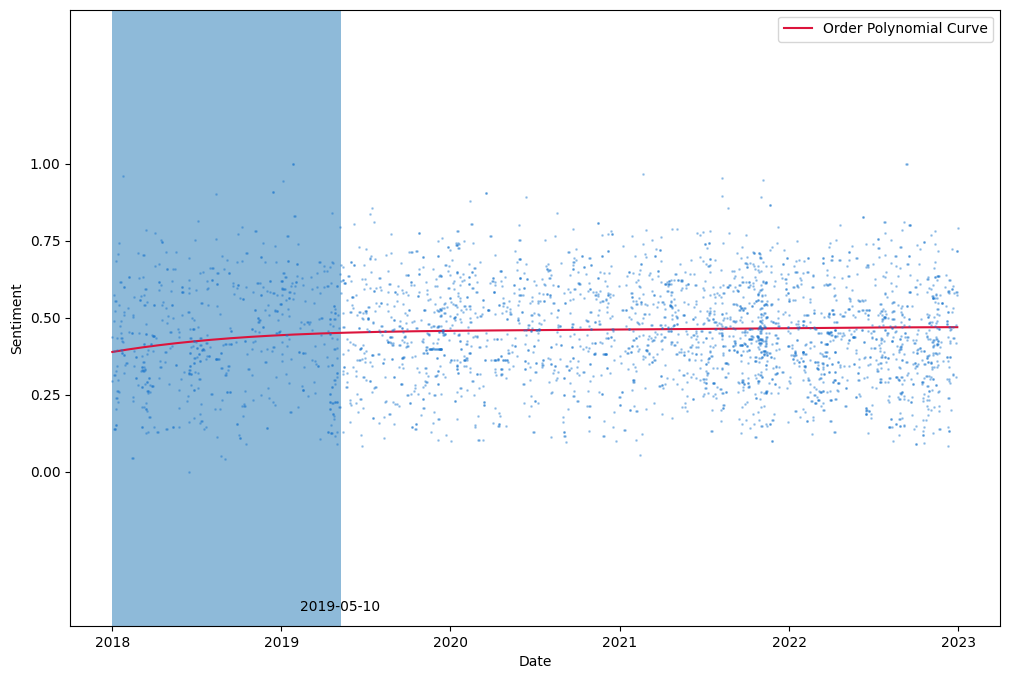

In [ ]:
bbc_unprocess_agg_df_scatter = bbc_unprocess_agg_df.iloc[:, [0,3]].rename({0: "date", 3: "sentiment"}, axis=1)
bbc_unprocess_agg_df_scatter["date"] = pd.to_datetime(bbc_unprocess_agg_df_scatter["date"])
bbc_unprocess_agg_df_scatter = bbc_unprocess_agg_df_scatter.set_index("date")
bbc_unprocess_agg_df_scatter["sentiment"] = normalize_data(bbc_unprocess_agg_df_scatter["sentiment"])

orderth = 5
model_poly = np.poly1d(np.polyfit(np.linspace(1, len(bbc_unprocess_agg_df_scatter), len(bbc_unprocess_agg_df_scatter)), bbc_unprocess_agg_df_scatter.sentiment, orderth))
bbc_y = model_poly(x)
bbc_kn = KneeLocator(x, bbc_y, curve='concave', direction='increasing').knee

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between([dates[int(i)-1] for i in x], -0.5, 1.5, where = x <= bbc_kn, alpha=0.5)
ax.plot(dates, bbc_y, color="#DC143C", label="Order Polynomial Curve")
ax.plot_date(bbc_unprocess_agg_df_scatter.index, bbc_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.3, color="#1874CD")
ax.text(dates[int(bbc_kn)-90], -0.45, dates[int(bbc_kn)-1].strftime("%Y-%m-%d"))
ax.set_ylim([-0.5,1.5])
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
ax.set_yticklabels(["", "", "0.00", "0.25", "0.50", "0.75", "1.00", "", ""])
for i in [0, 1,-2,-1]:
    ax.yaxis.get_major_ticks()[i].draw = lambda *args:None

In [ ]:
# nytimes_unprocess = pre_workflow("nytimes", words_need, process=False)
# nytimes_unprocess = nytimes_unprocess[nytimes_unprocess[1].map(lambda x: x.split()!=[] if x is not None else False)]
# nytimes_coffee_break_df = coffee_break(text = nytimes_unprocess[1], time = nytimes_unprocess[0], n_breaks = 3,
#                                        date_format = 'eur', time_freq = 'M', preprocess = True, model = "vader", skip = stopwords_all)

In [ ]:
# for index, line in tqdm(nytimes_unprocess_agg_df.iterrows(), total=len(nytimes_unprocess_agg_df)):
#     if index < 11824:
#         continue
#     scores = []
#     for item in line[2]:
#         try:
#             result = multilingual_classifier(item)
#             scores.append(int(result[0]["label"].split()[0]) - 1 + result[0]["score"])
#         except RuntimeError:
#             items = textwrap.wrap(item, len(item)//1.9)
#             for item in items:
#                 result = multilingual_classifier(item)
#                 scores.append(int(result[0]["label"].split()[0]) - 1 + result[0]["score"])
#     nytimes_unprocess_agg_df.iloc[index, 3] = np.mean(scores)

In [ ]:
# nytimes_unprocess_agg = nytimes_unprocess.groupby(nytimes_unprocess.index // 3)[1].agg(lambda x: x.iloc[0]+ " \n " + x.iloc[1] + " \n " + x.iloc[2]).to_frame()
# nytimes_unprocess_agg_time = nytimes_unprocess.groupby(nytimes_unprocess.index // 3)[0].agg(lambda x: x.iloc[0]).to_frame()
# nytimes_unprocess_agg_df = pd.concat([nytimes_unprocess_agg_time, nytimes_unprocess_agg], axis=1)
# nytimes_unprocess_agg_df[2] = nytimes_unprocess_agg_df[1].map(lambda x: [i.strip() for i in re.split("\.|\?|\!|\n", x) if i not in [" ", "", "'", "\""]])
# nytimes_unprocess_agg_df[3] = 0

In [ ]:
nytimes_unprocess_agg_df = pd.read_csv('nytimes_unprocess_agg_df.csv', index_col=0, names=[0,1,2,3,4,5], header=0)

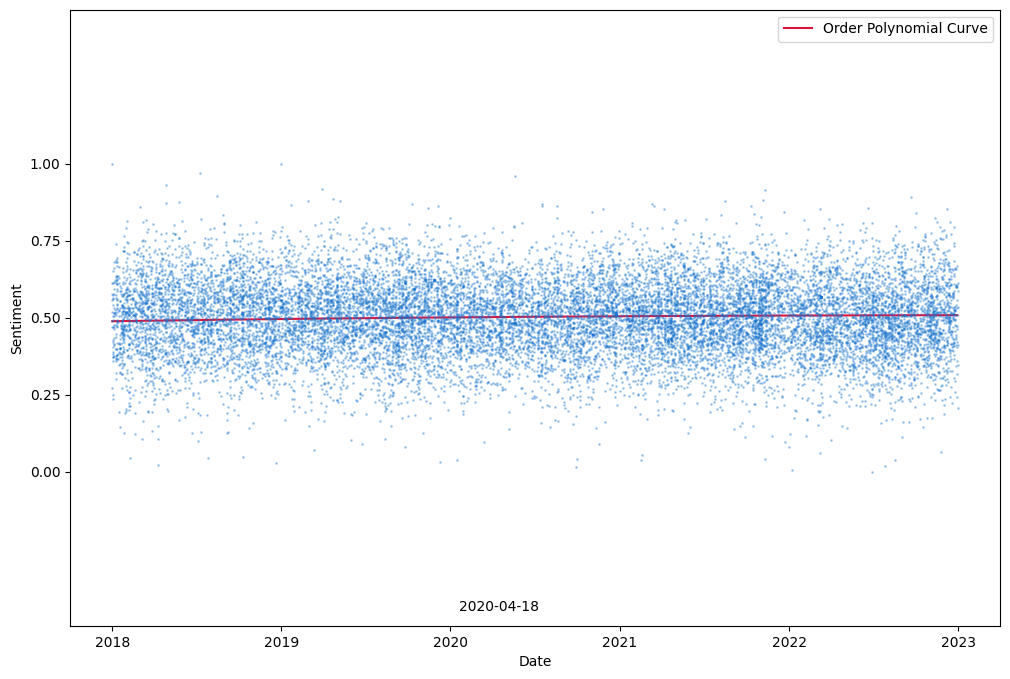

In [ ]:
nytimes_unprocess_agg_df_scatter = nytimes_unprocess_agg_df.iloc[:, [0,3]].rename({0: "date", 3: "sentiment"}, axis=1)
nytimes_unprocess_agg_df_scatter["date"] = pd.to_datetime(nytimes_unprocess_agg_df_scatter["date"])
nytimes_unprocess_agg_df_scatter = nytimes_unprocess_agg_df_scatter.set_index("date")
nytimes_unprocess_agg_df_scatter["sentiment"] = normalize_data(nytimes_unprocess_agg_df_scatter["sentiment"])

orderth = 5
model_poly = np.poly1d(np.polyfit(np.linspace(1, len(nytimes_unprocess_agg_df_scatter), len(nytimes_unprocess_agg_df_scatter)), nytimes_unprocess_agg_df_scatter.sentiment, orderth))
nytimes_y = model_poly(x)
nytimes_kn = KneeLocator(x, nytimes_y, curve='concave', direction='increasing').knee

fig, ax = plt.subplots(figsize=(12,8))
# ax.fill_between([dates[int(i)-1] for i in x], -0.5, 1.5, where = x <= nytimes_kn, alpha=0.5)
ax.plot(dates, nytimes_y, color="#DC143C", label="Order Polynomial Curve")
ax.plot_date(nytimes_unprocess_agg_df_scatter.index, nytimes_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.3, color="#1874CD")
ax.text(dates[int(nytimes_kn)-90], -0.45, dates[int(nytimes_kn)-1].strftime("%Y-%m-%d"))
ax.set_ylim([-0.5,1.5])
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
ax.set_yticklabels(["", "", "0.00", "0.25", "0.50", "0.75", "1.00", "", ""])
for i in [0, 1,-2,-1]:
    ax.yaxis.get_major_ticks()[i].draw = lambda *args:None

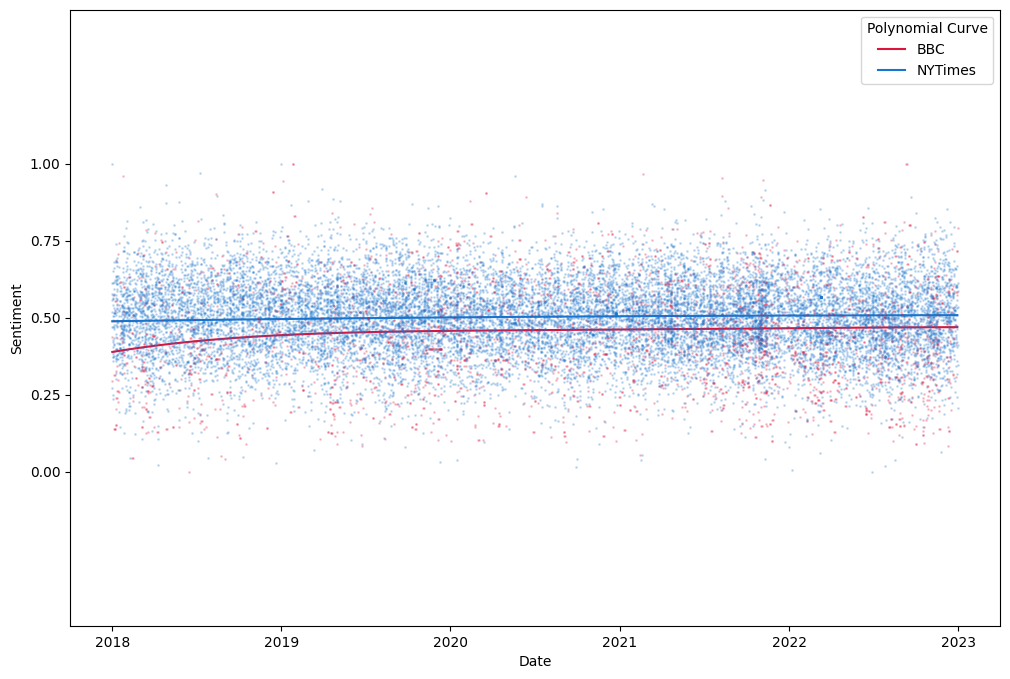

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(dates, bbc_y, color="#DC143C", label="BBC")
ax.plot(dates, nytimes_y, color="#1874CD", label="NYTimes")
ax.plot_date(bbc_unprocess_agg_df_scatter.index, bbc_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.2, color="#DC143C")
ax.plot_date(nytimes_unprocess_agg_df_scatter.index, nytimes_unprocess_agg_df_scatter["sentiment"], xdate=True, ydate=False, markersize=1, alpha=0.2, color="#1874CD")
ax.set_ylim([-0.5,1.5])
ax.legend(title="Polynomial Curve")
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment")
ax.set_yticklabels(["", "", "0.00", "0.25", "0.50", "0.75", "1.00", "", ""])
for i in [0, 1,-2,-1]:
    ax.yaxis.get_major_ticks()[i].draw = lambda *args:None

### Topic modeling

In [ ]:
# bbc_unprocess_agg_df_temp = bbc_unprocess_agg_df[[0, 1]]
# bbc_unprocess_agg_df_temp[2] = "BBC"
# nytimes_unprocess_agg_df_temp = nytimes_unprocess_agg_df[[0, 1]]
# nytimes_unprocess_agg_df_temp[2] = "NYTimes"
# data_unprocess_agg_df = pd.concat([bbc_unprocess_agg_df_temp, nytimes_unprocess_agg_df_temp], axis=0)
# data_unprocess_agg_df = data_unprocess_agg_df.sort_values(0)

# data_topic_model = BERTopic(verbose=False)
# data_topics, data_probs = data_topic_model.fit_transform(data_unprocess_agg_df[1])
# data_all_topics = data_topic_model.get_topic_info()
# data_document_topics = data_topic_model.get_document_info(data_unprocess_agg_df[1])
# data_unprocess_agg_df[4] = data_document_topics["Name"]
# data_unprocess_agg_df[5] = data_document_topics["Probability"]

In [ ]:
data_unprocess_agg_df = pd.read_csv('data_unprocess_agg_df.csv', index_col=0, names=[0, 1, 2, 4, 5], header=0)

In [ ]:
data_unprocess_agg_df_lda = data_unprocess_agg_df[[0, 4, 5]]
data_unprocess_agg_df_lda_pivot = pd.pivot_table(data_unprocess_agg_df_lda, index=0, columns=4, values=5, aggfunc='sum').fillna(0)
data_unprocess_agg_df_lda_pivot.index = pd.to_datetime(data_unprocess_agg_df_lda_pivot.index)
data_unprocess_agg_df_lda_pivot_year = data_unprocess_agg_df_lda_pivot.groupby(data_unprocess_agg_df_lda_pivot.index.year).sum()

In [ ]:
data_bbc_unprocess_agg_df = data_unprocess_agg_df[data_unprocess_agg_df[2] == "BBC"]
data_nytimes_unprocess_agg_df = data_unprocess_agg_df[data_unprocess_agg_df[2] == "NYTimes"]
data_bbc_unprocess_agg_df_lda_pivot = pd.pivot_table(data_bbc_unprocess_agg_df, index=0, columns=4, values=5, aggfunc='sum').fillna(0)
data_bbc_unprocess_agg_df_lda_pivot.index = pd.to_datetime(data_bbc_unprocess_agg_df_lda_pivot.index)
data_bbc_unprocess_agg_df_lda_pivot_year = data_bbc_unprocess_agg_df_lda_pivot.groupby(data_bbc_unprocess_agg_df_lda_pivot.index.year).sum()
data_nytimes_unprocess_agg_df_lda_pivot = pd.pivot_table(data_nytimes_unprocess_agg_df, index=0, columns=4, values=5, aggfunc='sum').fillna(0)
data_nytimes_unprocess_agg_df_lda_pivot.index = pd.to_datetime(data_nytimes_unprocess_agg_df_lda_pivot.index)
data_nytimes_unprocess_agg_df_lda_pivot_year = data_nytimes_unprocess_agg_df_lda_pivot.groupby(data_nytimes_unprocess_agg_df_lda_pivot.index.year).sum()
data_bbc_unprocess_agg_df_lda_pivot_year_normal = data_bbc_unprocess_agg_df_lda_pivot_year.T.apply(normalize_data).apply(lambda x: x / x.sum()).T
data_bbc_unprocess_agg_df_lda_pivot_year_normal = data_bbc_unprocess_agg_df_lda_pivot_year_normal.reindex(sorted(data_bbc_unprocess_agg_df_lda_pivot_year_normal.columns, key=lambda x: int(x.split("_")[0])), axis=1)
data_nytimes_unprocess_agg_df_lda_pivot_year_normal = data_nytimes_unprocess_agg_df_lda_pivot_year.T.apply(normalize_data).apply(lambda x: x / x.sum()).T
data_nytimes_unprocess_agg_df_lda_pivot_year_normal = data_nytimes_unprocess_agg_df_lda_pivot_year_normal.reindex(sorted(data_nytimes_unprocess_agg_df_lda_pivot_year_normal.columns, key=lambda x: int(x.split("_")[0])), axis=1)

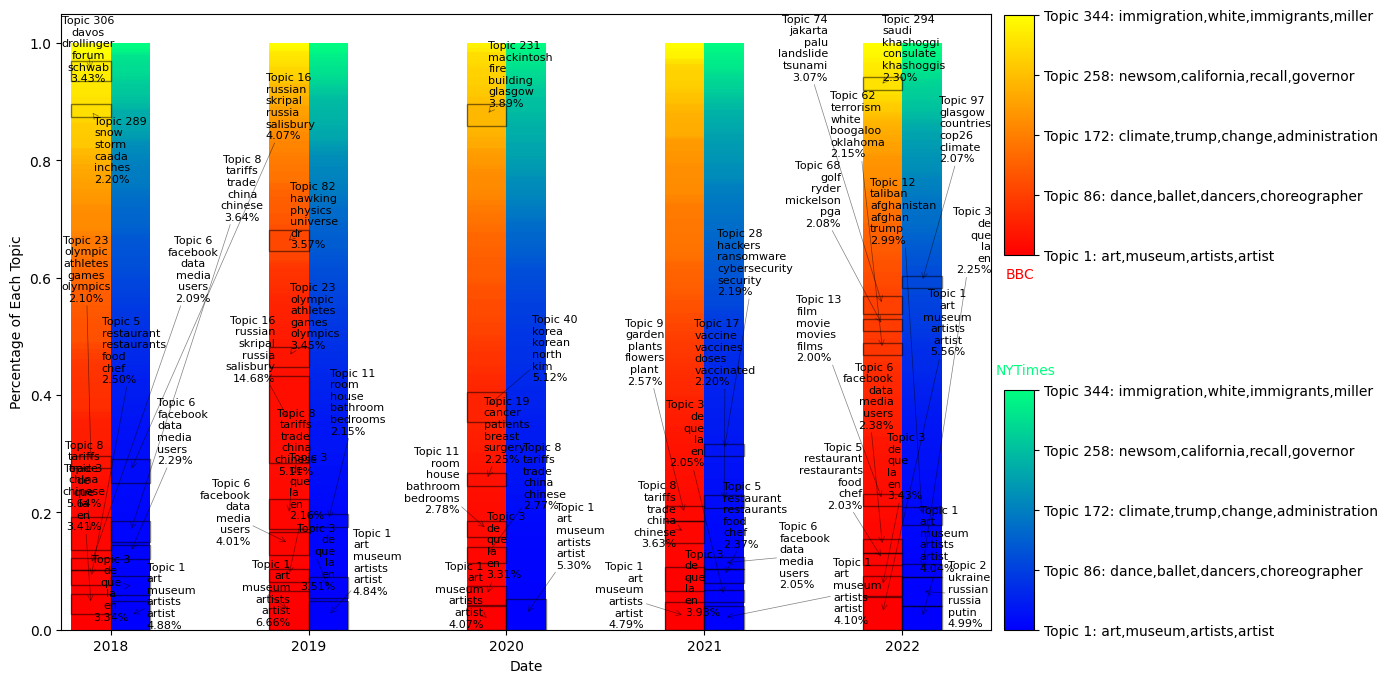

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

colors_autumn = [cmap_autumn(decimal) for decimal in np.linspace(0.000001, 0.999999, data_bbc_unprocess_agg_df_lda_pivot_year_normal.shape[1])]
colors_winter = [cmap_winter(decimal) for decimal in np.linspace(0.000001, 0.999999, data_nytimes_unprocess_agg_df_lda_pivot_year_normal.shape[1])]

data_bbc_unprocess_agg_df_lda_pivot_year_normal.plot(kind='bar', stacked=True, position=1, ax=ax, width=0.2, color=colors_autumn)
data_nytimes_unprocess_agg_df_lda_pivot_year_normal.plot(kind='bar', stacked=True, position=0, ax=ax, width=0.2, color=colors_winter)

threshold = 0.02

ax_texts = []
for index, (year, row) in enumerate(data_bbc_unprocess_agg_df_lda_pivot_year_normal.iterrows()):
    values_before = 0
    for topic, value in row.iteritems():
        if value >= threshold:
            topics = topic.split("_")
            ax_texts.append(ax.text(index - 0.1, values_before + value / 2, "Topic %d\n" % (int(topics[0]) + 1) + "\n".join(topics[1:]) + "\n%.2f%%" % (value*100), va = 'center', ha = 'center', size=8))
            ax.add_patch(patches.Rectangle((index - 0.2, values_before), 0.2, value, linewidth=1, edgecolor='black', facecolor='none', alpha=0.5))
        values_before += value

for index, (year, row) in enumerate(data_nytimes_unprocess_agg_df_lda_pivot_year_normal.iterrows()):
    values_before = 0
    for topic, value in row.iteritems():
        if value >= threshold:
            topics = topic.split("_")
            ax_texts.append(ax.text(index + 0.1, values_before + value / 2, "Topic %d\n" % (int(topics[0]) + 1) + "\n".join(topics[1:]) + "\n%.2f%%" % (value*100), va = 'center', ha = 'center', size=8))
            ax.add_patch(patches.Rectangle((index, values_before), 0.2, value, linewidth=1, edgecolor='black', facecolor='none', alpha=0.5))
        values_before += value

ax.set_xlabel("Date")
ax.set_ylabel("Percentage of Each Topic")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# ax.legend(title="Topics Over %.2f%%" % (threshold * 100), handles=[patches.Patch(color=get_cmap('autumn')(1), label='BBC'), patches.Patch(color=get_cmap('winter')(1), label='NYTimes')], bbox_to_anchor=(1.18, 1))
ax.legend().set_visible(False)
adjust_text(ax_texts, arrowprops=dict(arrowstyle="->", color='black', lw=0.5, alpha=0.5))

list_ticks = [0, 0.25, 0.5, 0.75, 1]
list_all_topics = [",".join(i.split("_")[1:]) for i in  data_nytimes_unprocess_agg_df_lda_pivot_year_normal.columns]
# May not be the exact point
list_all_topics = list_all_topics + [list_all_topics[-1]] * 2
num_topics = data_nytimes_unprocess_agg_df_lda_pivot_year_normal.shape[1]
list_topics = ["Topic %d: %s" % (int(i * num_topics) + 1, list_all_topics[int(i * num_topics) + 1]) for i in list_ticks]

plt_sm1 = plt.cm.ScalarMappable(cmap=cmap_autumn, norm=plt.Normalize(vmin=0, vmax=1))
plt_sm1._A = []
axins1 = inset_axes(ax, width='10%', height='2%', bbox_to_anchor=(830, -11290, 300, 12000), loc='upper right')
cbar1 = fig.colorbar(plt_sm1, cax=axins1, orientation='vertical', ticks=list_ticks)
cbar1.ax.set_yticklabels(list_topics)

plt_sm2 = plt.cm.ScalarMappable(cmap=cmap_winter, norm=plt.Normalize(vmin=0, vmax=1))
plt_sm2._A = []
axins2 = inset_axes(ax, width='10%', height='2%', bbox_to_anchor=(830, -11665, 300, 12000), loc='upper right')
cbar2 = fig.colorbar(plt_sm2, cax=axins2, orientation='vertical', ticks=list_ticks)
cbar2.ax.set_yticklabels(list_topics)

plt.figtext(0.912, 0.55, "BBC", color=colors_autumn[0])
plt.figtext(0.904, 0.43, "NYTimes", color=colors_winter[-1]);


In [ ]:
# bbc_processed[2] = "BBC"
# nytimes_processed[2] = "NYTimes"
# data_processed = pd.concat([bbc_processed, nytimes_processed], axis=0).reset_index(drop=True)
# data_processed[1] = data_processed["1"].map(ast.literal_eval)
# data_processed["0"] = pd.to_datetime(data_processed["0"])

# id2word = corpora.Dictionary(data_processed[1])
# corpus = [id2word.doc2bow(text) for text in data_processed[1]]

# # num_topics = 20
# # lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=706)
# # lda_model.save("lda_model")

lda_model = gensim.models.LdaMulticore.load("lda_model")
lda_topics = [("Topic %d" % (i+1), ", ".join(re.findall(r'"(.+?)"', j))) for i, j in lda_model.print_topics()]

# for i, j in lda_topics:
#   data_processed[i] = 0

# for i in range(len(corpus)):
#   for x, y in lda_model.get_document_topics(corpus[i]):
#     data_processed.at[i, "Topic %d" % (x+1)] = y

In [ ]:
data_processed = pd.read_csv("data_processed.csv", index_col=0)
data_processed["0"] = pd.to_datetime(data_processed["0"])

In [ ]:
freq = "Y"
if freq == "Y":
  time_freq = "%Y"
elif freq == "M":
  time_freq = "%Y-%m"
elif freq == "D":
  time_freq = "%Y-%m-%d"
data_bbc_processed = data_processed[data_processed["2"] == "BBC"]
data_nytimes_processed = data_processed[data_processed["2"] == "NYTimes"]
data_bbc_processed_group_day = data_bbc_processed.groupby(pd.Grouper(key='0', freq=freq))
data_nytimes_processed_group_day = data_nytimes_processed.groupby(pd.Grouper(key='0', freq=freq))
data_bbc_processed_group_day_topics = pd.concat([data_bbc_processed_group_day['Topic %d' % i].sum() for i in range(1, 21)], axis=1)
data_nytimes_processed_group_day_topics = pd.concat([data_nytimes_processed_group_day['Topic %d' % i].sum() for i in range(1, 21)], axis=1)
data_bbc_processed_group_day_topics_normal = data_bbc_processed_group_day_topics.T.apply(normalize_data).apply(lambda x: x / x.sum()).T
data_nytimes_processed_group_day_topics_normal = data_nytimes_processed_group_day_topics.T.apply(normalize_data).apply(lambda x: x / x.sum()).T

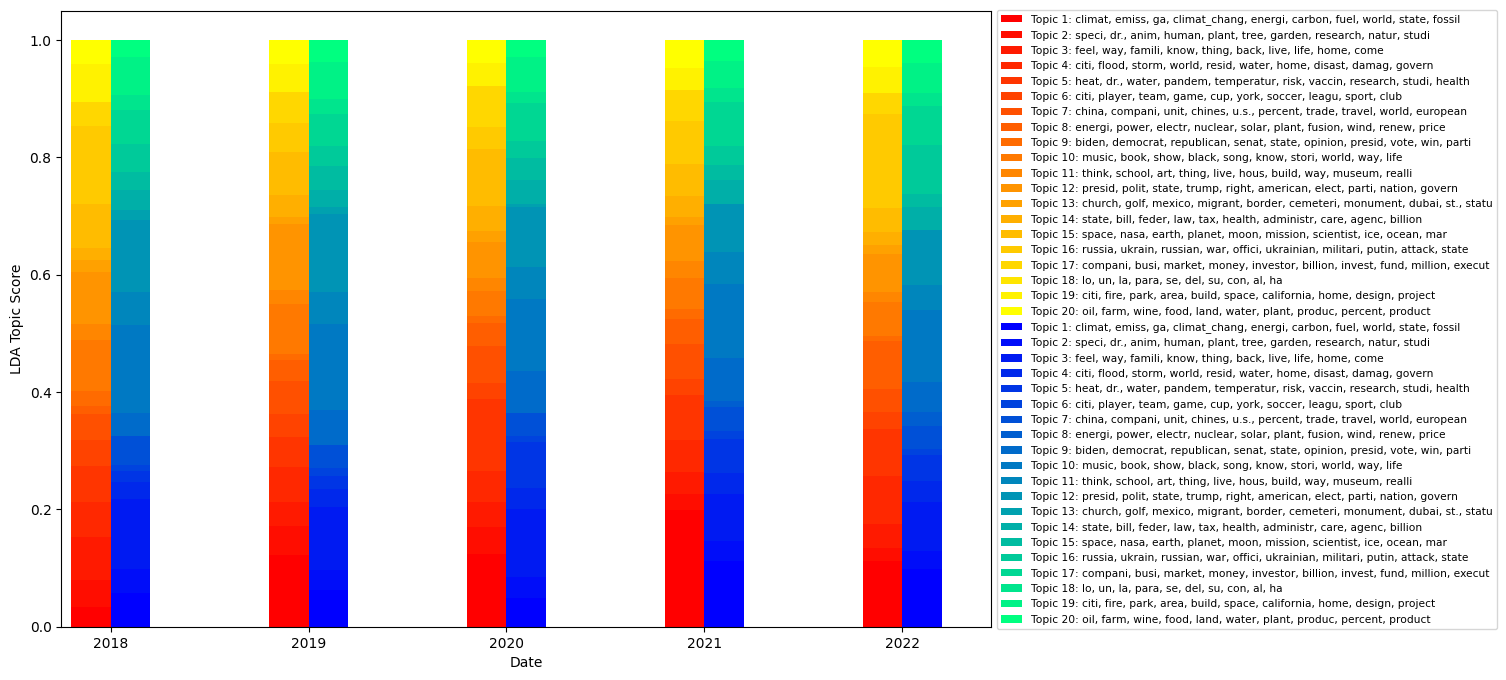

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

colors_autumn = [cmap_autumn(decimal) for decimal in np.linspace(0.000001, 0.999999, data_bbc_processed_group_day_topics_normal.shape[1])]
colors_winter = [cmap_winter(decimal) for decimal in np.linspace(0.000001, 0.999999, data_nytimes_processed_group_day_topics_normal.shape[1])]

data_bbc_processed_group_day_topics_normal.plot(kind='bar', stacked=True, position=1, ax=ax, width=0.2, color=colors_autumn)
data_nytimes_processed_group_day_topics_normal.plot(kind='bar', stacked=True, position=0, ax=ax, width=0.2, color=colors_winter)
ax.set_xlabel("Date")
ax.set_ylabel("LDA Topic Score")
ax.set_xticklabels([i.strftime(time_freq) for i in data_bbc_processed_group_day_topics_normal.index], rotation=0)
ax.legend(labels=[i + ": " + j for i, j in lda_topics + lda_topics], bbox_to_anchor=(1, 1.01), prop={'size': 7.7});

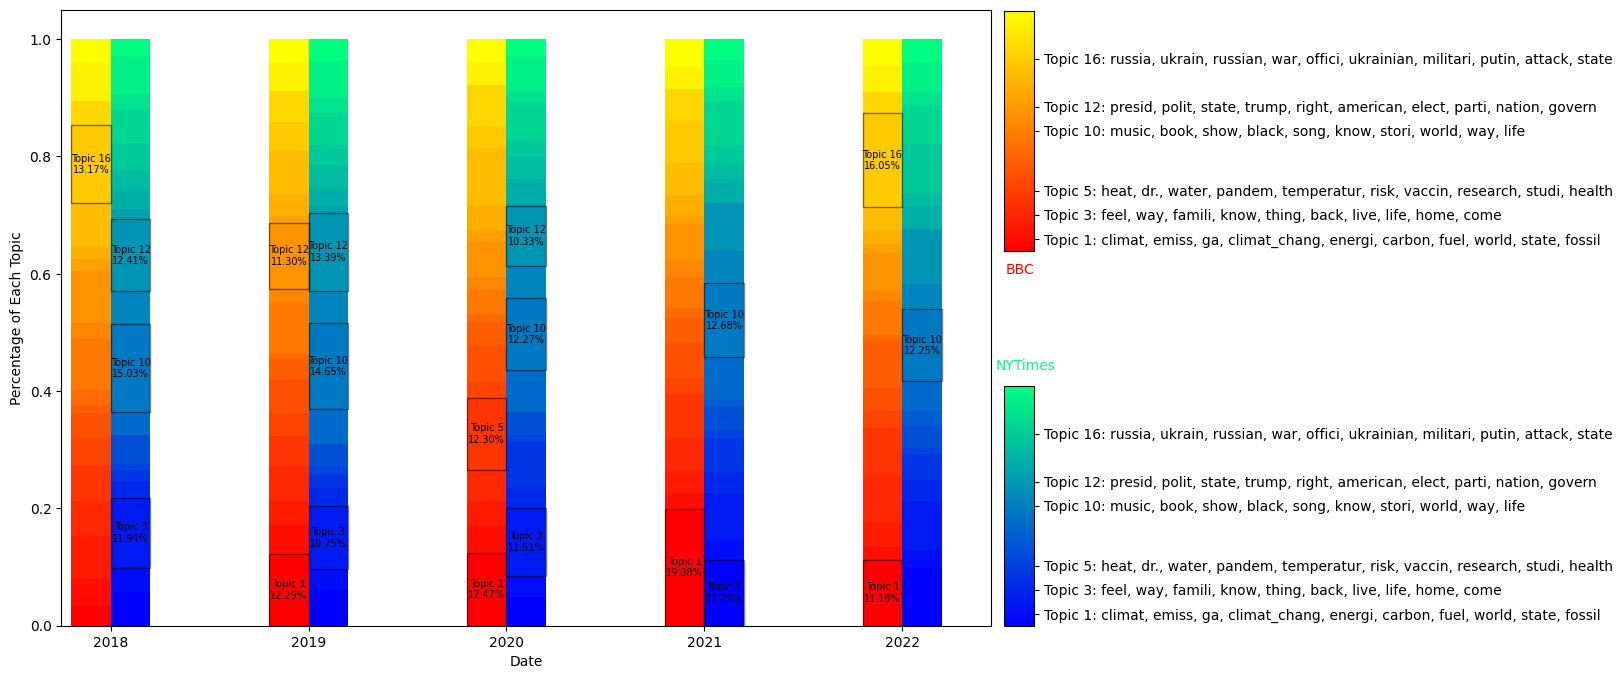

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

colors_autumn = [cmap_autumn(decimal) for decimal in np.linspace(0.000001, 0.999999, data_bbc_processed_group_day_topics_normal.shape[1])]
colors_winter = [cmap_winter(decimal) for decimal in np.linspace(0.000001, 0.999999, data_nytimes_processed_group_day_topics_normal.shape[1])]

data_bbc_processed_group_day_topics_normal.plot(kind='bar', stacked=True, position=1, ax=ax, width=0.2, color=colors_autumn)
data_nytimes_processed_group_day_topics_normal.plot(kind='bar', stacked=True, position=0, ax=ax, width=0.2, color=colors_winter)

threshold = 0.1

ax_texts = []
for index, (year, row) in enumerate(data_bbc_processed_group_day_topics_normal.iterrows()):
    values_before = 0
    for topic, value in row.iteritems():
        if value >= threshold:
            topics = topic.split("_")
            ax_texts.append(ax.text(index - 0.1, values_before + value / 2, topic + "\n%.2f%%" % (value*100), va = 'center', ha = 'center', size=7))
            ax.add_patch(patches.Rectangle((index - 0.2, values_before), 0.2, value, linewidth=1, edgecolor='black', facecolor='none', alpha=0.5))
        values_before += value

for index, (year, row) in enumerate(data_nytimes_processed_group_day_topics_normal.iterrows()):
    values_before = 0
    for topic, value in row.iteritems():
        if value >= threshold:
            topics = topic.split("_")
            ax_texts.append(ax.text(index + 0.1, values_before + value / 2, topic + "\n".join(topics[1:]) + "\n%.2f%%" % (value*100), va = 'center', ha = 'center', size=7))
            ax.add_patch(patches.Rectangle((index, values_before), 0.2, value, linewidth=1, edgecolor='black', facecolor='none', alpha=0.5))
        values_before += value

ax.set_xlabel("Date")
ax.set_ylabel("Percentage of Each Topic")
ax.set_xticklabels([i.strftime(time_freq) for i in data_bbc_processed_group_day_topics_normal.index], rotation=0)

ax.legend().set_visible(False)
# adjust_text(ax_texts, arrowprops=dict(arrowstyle="->", color='black', lw=0.5, alpha=0.5))

list_ticks = [1, 3, 5, 10, 12, 16]
list_topics = ["%s: %s" % lda_topics[i-1] for i in list_ticks]

plt_sm1 = plt.cm.ScalarMappable(cmap=cmap_autumn, norm=plt.Normalize(vmin=0, vmax=1))
plt_sm1._A = []
axins1 = inset_axes(ax, width='10%', height='2%', bbox_to_anchor=(830, -11290, 300, 12000), loc='upper right')
cbar1 = fig.colorbar(plt_sm1, cax=axins1, orientation='vertical', ticks=[i/20 for i in list_ticks])
cbar1.ax.set_yticklabels(list_topics)

plt_sm2 = plt.cm.ScalarMappable(cmap=cmap_winter, norm=plt.Normalize(vmin=0, vmax=1))
plt_sm2._A = []
axins2 = inset_axes(ax, width='10%', height='2%', bbox_to_anchor=(830, -11665, 300, 12000), loc='upper right')
cbar2 = fig.colorbar(plt_sm2, cax=axins2, orientation='vertical', ticks=[i/20 for i in list_ticks])
cbar2.ax.set_yticklabels(list_topics)

plt.figtext(0.912, 0.55, "BBC", color=colors_autumn[0])
plt.figtext(0.904, 0.43, "NYTimes", color=colors_winter[-1]);
